# Churn Modeling and Feature Interpretation

This notebook examines the churn model trained by the steam_real pipeline.

Context:
- Churn is defined as the bottom 20 percent of users by total playtime.
- Engagement features include total playtime, sessions, and game diversity.
- Because churn is derived from engagement depth, this model reflects a
  proxy churn formulation rather than real-world behavioral churn.

The goal of this notebook is not to claim predictive performance, but to:
- validate the modeling pipeline
- inspect feature contributions
- understand the implications and limitations of proxy churn modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
sns.set(style="whitegrid")

In [3]:
PROJECT_ROOT = Path("..").resolve()
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
ML_DATASET_PATH = PROCESSED_DIR / "ml_dataset.parquet"
MODEL_PATH = MODELS_DIR / "churn_model.pkl"

In [4]:
ML_DATASET_PATH, MODEL_PATH

(PosixPath('/Users/sanjaydilip/Desktop/Code/Projects/sim2real user engagement/steam_real/data/processed/ml_dataset.parquet'),
 PosixPath('/Users/sanjaydilip/Desktop/Code/Projects/sim2real user engagement/steam_real/models/churn_model.pkl'))

In [5]:
ml_df = pd.read_parquet(ML_DATASET_PATH)
with open(MODEL_PATH, "rb") as f:
    bundle = pickle.load(f)

In [6]:
model = bundle["model"]
stored_metrics = bundle.get("metrics", {})

In [7]:
ml_df.head(), stored_metrics

(   user_id  total_playtime_value  sessions  unique_games  avg_session_length  \
 0     5250                 225.5         6             6           37.583333   
 1    76767                1227.0        20            20           61.350000   
 2    86540                 255.0        15            15           17.000000   
 3   144736                   0.1         1             1            0.100000   
 4   181212                   2.2         2             2            1.100000   
 
    playtime_per_game  churned  
 0          37.583333        0  
 1          61.350000        0  
 2          17.000000        0  
 3           0.100000        1  
 4           1.100000        0  ,
 {'accuracy': 1.0,
  'precision_0': 1.0,
  'recall_0': 1.0,
  'precision_1': 1.0,
  'recall_1': 1.0,
  'roc_auc': np.float64(1.0)})

## Feature set and churn label

The model is trained using user-level engagement features.

Because churn is defined using total playtime, some degree of circularity
is expected when total playtime is included as a feature.

In [8]:
FEATURE_COLS = [
    "total_playtime_value",
    "sessions",
    "unique_games",
    "avg_session_length",
    "playtime_per_game",
]
X = ml_df[FEATURE_COLS]
y = ml_df["churned"]

In [9]:
X.shape, y.value_counts(normalize=True)

((11350, 5),
 churned
 0    0.7963
 1    0.2037
 Name: proportion, dtype: float64)

## Model evaluation

We evaluate the trained model on a held-out validation split.
Because the churn label is directly derived from engagement depth,
strong performance is expected and should not be over-interpreted.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [11]:
X_train.shape, X_val.shape

((9080, 5), (2270, 5))

In [12]:
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1808
           1       1.00      1.00      1.00       462

    accuracy                           1.00      2270
   macro avg       1.00      1.00      1.00      2270
weighted avg       1.00      1.00      1.00      2270



In [13]:
try:
    roc_auc = roc_auc_score(y_val, y_proba)
except ValueError:
    roc_auc = None

roc_auc

np.float64(1.0)

The near-perfect metrics observed here are a direct consequence of the
proxy churn definition.

The model is effectively learning the threshold that separates the
lowest playtime users from the rest, rather than discovering new
behavioral signals.

This result validates the pipeline, not real-world predictive power.

## Feature importance analysis

Although the churn definition introduces circularity, feature importance
still provides insight into how engagement depth is represented in the data.

In [14]:
importances = model.feature_importances_
feat_importance = (
    pd.Series(importances, index=FEATURE_COLS)
    .sort_values(ascending=False)
)

feat_importance

total_playtime_value    0.451714
playtime_per_game       0.277602
avg_session_length      0.236485
sessions                0.020936
unique_games            0.013264
dtype: float64

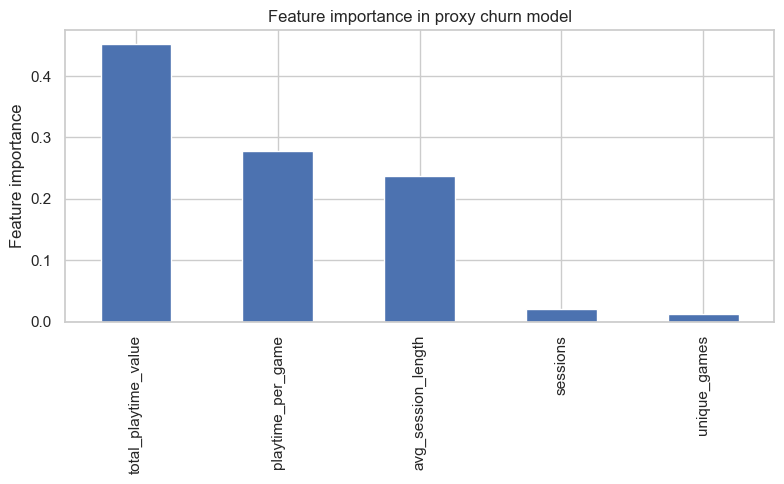

In [15]:
plt.figure(figsize=(8, 5))
feat_importance.plot(kind="bar")
plt.ylabel("Feature importance")
plt.title("Feature importance in proxy churn model")
plt.tight_layout()
plt.show()

Total playtime dominates feature importance, which is expected given that
churn is derived directly from playtime.

Secondary features such as:
- number of unique games
- playtime per game

still contribute, indicating that engagement breadth and intensity provide
additional structure beyond raw volume.

## Example user predictions

To make the model output concrete, we inspect a small sample of users and
their predicted churn probabilities.

In [16]:
sample_users = ml_df.sample(5, random_state=42).copy()
sample_users[
    ["user_id"] + FEATURE_COLS + ["churned"]
]

,user_id,total_playtime_value,sessions,unique_games,avg_session_length,playtime_per_game,churned
8492,217391754,0.7,1,1,0.700000,0.700000,1
9346,241742834,5.2,2,2,2.600000,2.600000,0
1402,60557056,181.6,4,4,45.400000,45.400000,0
1617,67083031,304.1,12,12,25.341667,25.341667,0
4929,148246305,327.4,9,9,36.377778,36.377778,0


In [17]:
sample_X = sample_users[FEATURE_COLS]
sample_users["pred_churn_proba"] = model.predict_proba(sample_X)[:, 1]
sample_users["pred_churn_label"] = (sample_users["pred_churn_proba"] >= 0.5).astype(int)
sample_users[
    ["user_id"] + FEATURE_COLS + ["churned", "pred_churn_label", "pred_churn_proba"]
]

,user_id,total_playtime_value,sessions,unique_games,avg_session_length,playtime_per_game,churned,pred_churn_label,pred_churn_proba
8492,217391754,0.7,1,1,0.700000,0.700000,1,1,1.0
9346,241742834,5.2,2,2,2.600000,2.600000,0,0,0.0
1402,60557056,181.6,4,4,45.400000,45.400000,0,0,0.0
1617,67083031,304.1,12,12,25.341667,25.341667,0,0,0.0
4929,148246305,327.4,9,9,36.377778,36.377778,0,0,0.0


These examples illustrate how the model maps engagement depth to a churn
probability under the proxy churn definition.

Users with extremely low playtime receive near-certain churn probabilities,
while users with higher engagement are confidently classified as non-churned.
This behavior reflects the construction of the churn label and validates the
end-to-end modeling pipeline rather than real-world predictive uncertainty.

## Summary and limitations

In this notebook we:

- evaluated a churn model trained on user-level engagement features
- observed near-perfect performance due to proxy churn construction
- analyzed feature importance to understand engagement representations
- inspected example predictions for interpretability

Key limitations:
- churn is derived from engagement depth, introducing circularity
- performance metrics reflect label construction, not real-world accuracy
- timestamps are required for true churn modeling